In [1]:
import numpy as np
from tqdm import tqdm
import pymc3 as pm
import matplotlib.pyplot as plt
import time

# Cython attempt

In [ ]:
%load_ext Cython

In [ ]:
%%cython
cdef int i, j, k
i, j, k = (1, 2, 3)
print(i + j + k)

In [ ]:
%%cython
cdef int i, j, k
i, j, k = (1, 2, 3)
print(i + j + k)

In [ ]:
i, j, k = (1, 2, 3)
print(i + j + k)

In [ ]:
%%cython
import numpy as np
from tqdm import tqdm

cdef int val1, val2, val3, val4, dE, n, nsteps, main, H, J, Sn, T
cdef float testprob, testval

def mcmc_ising_cython(n = 200,
                      nsteps = 500000,
                      T = 1,
                      J = 1,
                      H = 0):
    
    
    # Initialize our ising system with random values -1 or 1
    lattice = np.random.choice([1, -1], size=(n, n))
    energy = 0
    spin = np.sum(lattice)
    
    for step in tqdm(range(nsteps)):

        i, j = np.random.randint(n, size = 2)
        
        main = lattice[i, j]
        val1 = lattice[(i - 1) % n, j]
        val2 = lattice[(i + 1) % n, j]
        val3 = lattice[i, (j - 1) % n]
        val4 = lattice[i, (j + 1) % n]
        # Boundary conditions and neighbours
        Sn = val1 + val2 + val3 + val4
        dE = 2 * main * (H + J * Sn)
        
        testprob = np.random.random()
        testval = np.exp(-dE/(T))
        
        if dE < 0 or testprob < testval:
            main = -main
            
    return lattice, nsteps, T

print(mcmc_ising_cython(nsteps = 1000000, T = 1))

# Our Ising Functions

In [ ]:
def mcmc_ising2(n = 200,
               nsteps = 500000,
               T = 1,
               J = 1,
               H = 0):
    """
    This system is just for efficiency testing purposes!
    """
    
    # Initialize our ising system with random values -1 or 1
    lattice = np.random.choice([1, -1], size=(n, n))
    energy = 0
    spin = np.sum(lattice)
    
    randtime = []
    neighbourtime = []
    temptime = []
    choicetime = []
    
    for step in tqdm(range(nsteps)):
        
        randstart = time.time()
        i, j = np.random.randint(n, size = 2)
        randstop = time.time()
        
        randtime.append(randstop - randstop)
        
        # Boundary conditions and neighbours
        neighbourstart = time.time()

        Sn = lattice[(i - 1) % n, j] + lattice[(i + 1) % n, j] + \
             lattice[i, (j - 1) % n] + lattice[i, (j + 1) % n]

        neighbourend = time.time()
        
        neighbourtime.append(neighbourend - neighbourstart)
        
        tempstart = time.time()
        dE = 2 * lattice[i, j] * (H + J * Sn)
        tempend = time.time()
        
        temptime.append(tempend - tempstart)
        
        choicestart = time.time()
        if dE < 0 or np.random.random() < np.exp(-dE/(T)):
            lattice[i, j] = -lattice[i, j]
        choiceend = time.time()
        
        choicetime.append(choiceend - choicestart)
        
        
    print(f"""
    
    Random int choice took {100*sum(randtime)/sum([sum(randtime), sum(neighbourtime), sum(temptime), sum(choicetime)])}
    Neighbour calc took {100*sum(neighbourtime)/sum([sum(randtime), sum(neighbourtime), sum(temptime), sum(choicetime)])}
    Energy calc took {100*sum(temptime)/sum([sum(randtime), sum(neighbourtime), sum(temptime), sum(choicetime)])}
    MCMC Choice took {100*sum(choicetime)/sum([sum(randtime), sum(neighbourtime), sum(temptime), sum(choicetime)])}
    """)
        

In [ ]:
#mcmc_ising2(nsteps = 10000000)

# Numba JIT implementation! super fast!

In [2]:
import numpy as np
from numba import jit

def mcmc_ising2(n = 200,
               nsteps = 20000000,
               T = 1,
               J = 1,
               H = 0):

    # initialize our lattice
    ising_lattice = np.random.choice([1, -1], size=(n, n))

    # From here on down we are in numba jit
    @jit(nopython=True)
    def ising_calculation(lattice):
        lattice = lattice

        for step in range(nsteps):

            i = np.random.randint(n)
            j = np.random.randint(n)

            # Boundary conditions and neighbours
            Sn = lattice[(i - 1) % n, j] + lattice[(i + 1) % n, j] + \
                 lattice[i, (j - 1) % n] + lattice[i, (j + 1) % n]
            dE = 2 * lattice[i, j] * (H + J * Sn)

            if dE < 0 or np.random.random() < np.exp(-dE/(T)):
                lattice[i, j] = -lattice[i, j]

        return lattice
    
    return ising_calculation(ising_lattice), nsteps, T

#mcmc_ising2()

# Playing with CUDA JIT

In [ ]:
# TEST DO NOT RUN
@jit(nopython=True)
def a_device_function(a, b):
    return a + b

a_device_function(5, 6)

In [ ]:
# TEST DO NOT RUN
from numba import cuda
print(cuda.gpus)

In [ ]:
# TEST DO NOT RUN
import numpy as np
from numba import jit
from numba import cuda


def mcmc_ising3(n = 200,
               nsteps = 20000000,
               T = 1,
               J = 1,
               H = 0):

    # initialize our lattice
    ising_lattice = np.random.choice([1, -1], size=(n, n))

    # From here on down we are in numba jit
    @cuda.jit(device=True)
    def ising_calculation(lattice):
        lattice = lattice

        for step in range(nsteps):

            i = np.random.randint(n)
            j = np.random.randint(n)

            # Boundary conditions and neighbours
            Sn = lattice[(i - 1) % n, j] + lattice[(i + 1) % n, j] + \
                 lattice[i, (j - 1) % n] + lattice[i, (j + 1) % n]
            dE = 2 * lattice[i, j] * (H + J * Sn)

            if dE < 0 or np.random.random() < np.exp(-dE/(T)):
                lattice[i, j] = -lattice[i, j]

        return lattice
    
    return ising_calculation(ising_lattice), nsteps, T

mcmc_ising3()

In [6]:
def mcmc_ising(n = 200,
               nsteps = 500000,
               T = 1,
               J = 1,
               H = 0):
    
    
    # Initialize our ising system with random values -1 or 1
    lattice = np.random.choice([1, -1], size=(n, n))
    energy = 0
    spin = np.sum(lattice)
    
    for step in tqdm(range(nsteps)):

        i, j = np.random.randint(n, size = 2)
            
        # Boundary conditions and neighbours
        Sn = lattice[(i - 1) % n, j] + lattice[(i + 1) % n, j] + \
             lattice[i, (j - 1) % n] + lattice[i, (j + 1) % n]
        dE = 2 * lattice[i, j] * (H + J * Sn)
        
        if dE < 0 or np.random.random() < np.exp(-dE/(T)):
            lattice[i, j] = -lattice[i, j]
            
    return lattice, nsteps, T


In [ ]:
#mcmc_ising()

# Pretty Plots!

In [3]:
def plot_ising_array(ising_system, save_plot = False, file_name = "ising_array"):
    """
    Creates a plot of a 2D numpy array with binary values.
    """
    import matplotlib.pyplot as plt
    from matplotlib import colors
    
    ising_system, nsteps, T = ising_system

    plt.figure(figsize=(7,7))
    plt.imshow(ising_system, cmap = colors.ListedColormap(['white', '#0550c6']))
    
    # Math for the correct position of the text
    x_pos = len(ising_system) * 1.05
    y_pos = len(ising_system) * 0.05
    
    # Title of the model
    title = "2D Ising Model " + str(len(ising_system)) +  "x" + str(len(ising_system))
    plt.text(x_pos, y_pos, title, bbox=dict(facecolor='red', alpha=0.2), size = 12)
    
    # Magnetization text
    magnetization = "Magnetization: " + str(round(abs(np.sum(ising_system))/(len(ising_system)**2)*100,2)) + "%"
    plt.text(x_pos, y_pos*3, magnetization, size = 12)
    
    # Metropolis steps text
    steps_text = "MCMC Steps: " + str(f"{nsteps:,}")
    plt.text(x_pos, y_pos*4, steps_text, size = 12)
    
    # Temperature text
    temp_text = "System Temp: " + str(T)
    plt.text(x_pos, y_pos*5, temp_text, size = 12)
    
    # Saving the plot if user selected True, as well as reformating filename
    if save_plot:
        file_name += ".png"
        plt.savefig(file_name, bbox_inches='tight', quality = 95)
    
    plt.show()
    
#plot_ising_array(mcmc_ising(n = 200, T = 1, nsteps = 2000000), save_plot = False)

100%|██████████| 1000000/1000000 [00:10<00:00, 97808.78it/s]


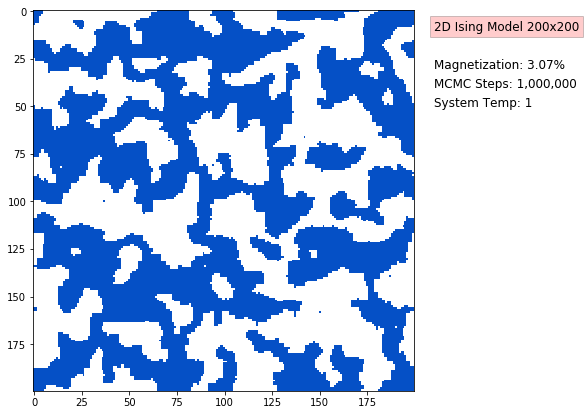

In [9]:
plot_ising_array(mcmc_ising(n = 200, T = 1, nsteps = 1000000), save_plot = False)

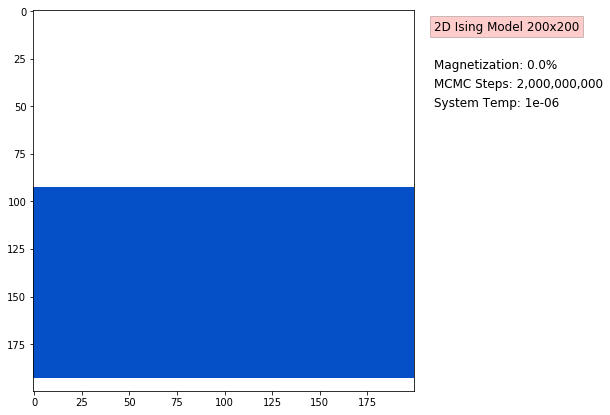

In [21]:
plot_ising_array(mcmc_ising2(n = 200, T = 0.000001, nsteps = 2000000000), save_plot = False)

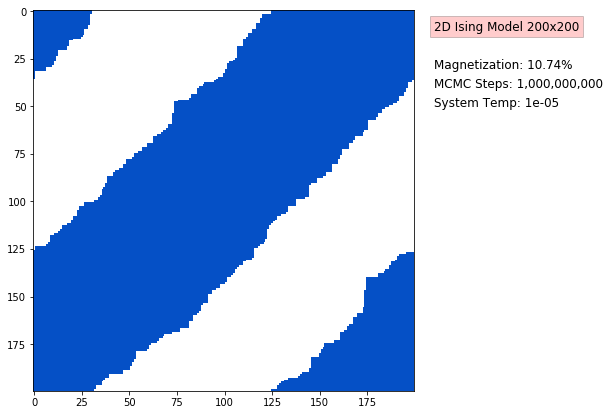

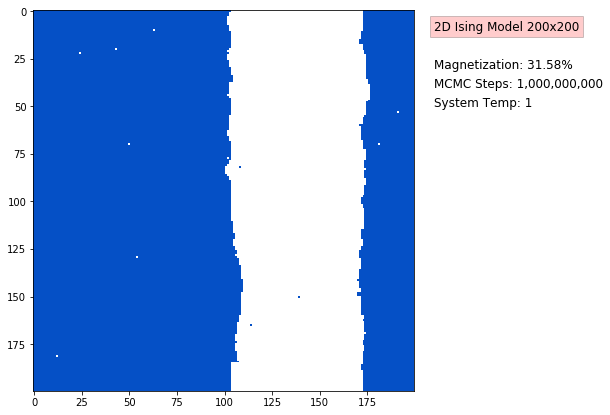

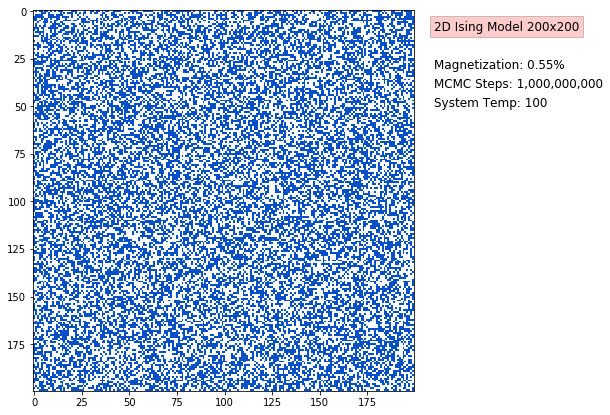

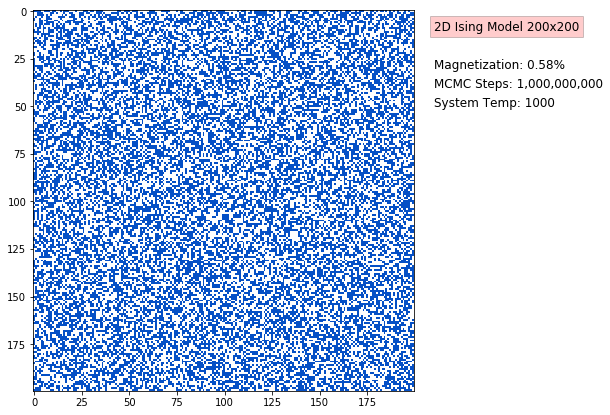

In [7]:
#plot_ising_array(mcmc_ising2(n = 200, T = 1, nsteps = 20000000), save_plot = False)

temp_list = [0.00001, 1, 100, 1000]

for val in temp_list:
    file_name = "ising_system_temp_" + str(val)
    plot_ising_array(mcmc_ising2(n = 200, T = val, nsteps = 1000000000), save_plot = True, file_name = file_name)

In [ ]:
#plot_ising_array(mcmc_ising(n = 200, T = 0.000001, nsteps = 500000))

# Animation Attempt